In [1]:
import pandas as pd

### Data 

In [2]:
from influxdb import DataFrameClient

config = {'host': "xxxxxxxx",
          'port': 8086,
          'username': "xxxxxxxx",
          'password': "xxxxxxxx",
          'database': "xxxxxxxx"}     

domino_client = DataFrameClient(host=config['host'],
                                port=config['port'],
                                username=config['username'],
                                password=config['password'],
                                database=config['database'])

config = {'host': "xxxxxxxxxxx",
          'port': 8086,
          'username': "solar",
          'password': "xxxxxxxxxxx",
          'database': "xxxxxxxxxxx"}

gc_client = DataFrameClient(host=config['host'],
                            port=config['port'],
                            username=config['username'],
                            password=config['password'],
                            database=config['database'])

In [3]:
def read_db(client, select_clause, field, return_local_time=False, offset=None, scale=1.) -> pd.DataFrame:
    """
        Fetches data from influx database
        Args:
            query_type: str
        Returns:
            >>> dataframe[field]: pd.DataFrame
    """
#     start_time, end_time = get_start_end_time(query_type, offset=offset)

#     log.info(f'Fetching {field} with {list(tags.values())} tags data for period from {start_time} to {end_time} (UTC time)')
#     # start_time = convert_to_strf(convert_to_utc(start_time))
#     # end_time = convert_to_strf(convert_to_utc(end_time))
#     start_time = convert_to_strf(start_time)
#     end_time = convert_to_strf(end_time)

#     select_clause = self.make_query(field_name=field,
#                                     measurement_name=measurement,
#                                     tags=tags,
#                                     start_time=start_time,
#                                     end_time=end_time,
#                                     freq=freq,
#                                     agg=agg,
#                                     scale=scale)
    res = client.query(select_clause)

    df_list, df_cols = [], []
    for key, column in res.items():
        df_list.append(res[key])
        df_cols.append(key[1][0][0])

    if df_list:
        # List is not empty
        data = pd.concat(df_list, axis=1).astype(float) #.fillna(method='bfill')
        data.columns = [field]
    else:
        data = pd.DataFrame(columns=[field])
        return data

    if return_local_time==True:
        # convert utc time to local time
        data.index = data.index.tz_convert('Europe/Helsinki').tz_localize(None)
    else:
        data.index = data.index.tz_localize(None)
    print(f"Retrieved data: {data}")
    return data

def make_query(field_name="price", measurement_name="nordicpower",
               tags={"Type":'FCR-N'}, start_time='now()', end_time="now()",
               freq='1h', agg='max', scale=1, fill='linear') -> str:
    """
        A wrapper function to generate string clauses for InfluxDBClient
    """
    # make condition string on tags
    tag = ""
    tag_name = ''
    for k, v in tags.items():
        tag += "\"{}\"=\'{}\' AND ".format(k, v)
        tag_name += ', \"{}\"'.format(k)
    # make full request string
    select_clause = ('SELECT {}(\"{}\")*{} FROM \"{}\" ' \
                     "WHERE {} time >= \'{}\' AND time < \'{}\' " \
                     'GROUP BY time({}){} fill({})'
                     ).format(agg, field_name, scale, measurement_name, tag,
                              start_time, end_time, freq, tag_name, fill)
    print(f'Requesting query: {select_clause}')
    return select_clause


### AIMS: 

    1 - check which forecast is better 
    2 - automate metric analysis
    

#### 1 - check which forecast is better 

In [4]:
# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License").
# You may not use this file except in compliance with the License.
# A copy of the License is located at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# or in the "license" file accompanying this file. This file is distributed
# on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
# express or implied. See the License for the specific language governing
# permissions and limitations under the License.

"""
This example shows how to fit a model and evaluate its predictions.
"""
import pprint
from functools import partial
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sys

# %matplotlib inline
import mxnet as mx
from mxnet import gluon

import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path


from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
# from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.canonical import CanonicalRNNEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.gp_forecaster import GaussianProcessEstimator
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.distribution.gaussian import GaussianOutput
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import Config, OutputType
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

mx.random.seed(0)
np.random.seed(0)

from typing import Optional

import numpy as np
from pydantic import PositiveInt

from gluonts.core.component import validated
from gluonts.dataset.common import DataEntry, Dataset
from gluonts.dataset.field_names import FieldName
from gluonts.model.estimator import Estimator
from gluonts.model.forecast import SampleForecast
from gluonts.model.predictor import FallbackPredictor, RepresentablePredictor
from gluonts.model.trivial.constant import ConstantPredictor
from gluonts.support.pandas import forecast_start


class MeanEstimator(Estimator):
    """
    An `Estimator` that computes the mean targets in the training data,
    in the trailing `prediction_length` observations, and produces
    a `ConstantPredictor` that always predicts such mean value.
    Parameters
    ----------
    prediction_length
        Prediction horizon.
    freq
        Frequency of the predicted data.
    num_samples
        Number of samples to include in the forecasts. Not that the samples
        produced by this predictor will all be identical.
    """

    @validated()
    def __init__(
        self,
        prediction_length: PositiveInt,
        freq: str,
        num_samples: PositiveInt,
    ) -> None:
        super().__init__()
        self.prediction_length = prediction_length
        self.freq = freq
        self.num_samples = num_samples

    def train(
        self,
        training_data: Dataset,
        validation_dataset: Optional[Dataset] = None,
    ) -> ConstantPredictor:
        contexts = np.array(
            [
                item["target"][-self.prediction_length :]
                for item in training_data
            ]
        )

        samples = np.broadcast_to(
            array=contexts.mean(axis=0),
            shape=(self.num_samples, self.prediction_length),
        )

        return ConstantPredictor(samples=samples, freq=self.freq)

class MovingAveragePredictor(RepresentablePredictor):
    """
    A :class:`Predictor` that predicts the moving average based on the
    last `context_length` elements of the input target.
    If `prediction_length` = 1, the output is the moving average
    based on the last `context_length` elements of the input target.
    If `prediction_length` > 1, the output is the moving average based on the
    last `context_length` elements of the input target, where
    previously calculated moving averages are appended at the end of the input target.
    Hence, for `prediction_length` larger than `context_length`, there will be
    cases where the moving average is calculated on top of previous moving averages.
    Parameters
    ----------
    context_length
        Length of the target context used to condition the predictions.
    prediction_length
        Length of the prediction horizon.
    freq
        Frequency of the predicted data.
    """

    @validated()
    def __init__(
        self,
        prediction_length: int,
        freq: str,
        context_length: Optional[int] = None,
    ) -> None:
        super().__init__(freq=freq, prediction_length=prediction_length)

        if context_length is not None:
            assert (
                context_length >= 1
            ), "The value of 'context_length' should be >= 1 or None"

        self.context_length = context_length

    def predict_item(self, item: DataEntry) -> SampleForecast:
        target = item["target"].tolist()

        for _ in range(self.prediction_length):
            if self.context_length is not None:
                window = target[-self.context_length :]
            else:
                window = target

            target.append(np.nanmean(window))

        return SampleForecast(
            samples=np.array([target[-self.prediction_length :]]),
            start_date=forecast_start(item),
            freq=self.freq,
            item_id=item.get(FieldName.ITEM_ID),
        )


def plot_prob_forecasts(ts_entry, forecast_entry, sample_id, prediction_length, plot_length, inline=True):
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()


def get_custom_dataset(names, horizon):
    """
    """
    freq = '15T' #'1H'
    dfs = []
    for name in names:
        clause = make_query(field_name=name,
                            measurement_name="dominoes", #nordicpower
                            tags={"Type":'FCR-N'}, 
                            start_time='2020-08-16 23:00:00', # '2015-01-01 23:00:00'
                            end_time="2021-02-07 23:23:00",
                            freq='15m', # '1H'
                            agg='max', 
                            scale=1,
                            fill='linear')

        df = read_db(domino_client, clause, field=name).abs()
        df = df.ffill().bfill()
        dfs.append(df)
        print(df)
    df = pd.concat(dfs, axis=1)
    train_start = '2020-08-16 23:00:00' # '2015-01-01 23:00:00'
    train_end = '2020-12-01 22:45:00'   #'2020-01-01 22:00:00'
    test_start = '2021-02-01 23:00:00' #'2020-01-01 23:00:00'
    test_end = '2021-03-15 22:45:00'  # '2021-01-18 22:45:00'
    
    train_target_values = df[:train_end].T.values
    print('train_target_values', train_target_values)
    test_target_values = df[:pd.Timestamp(test_start)].T.values 
    print('test_target_values', test_target_values)
    start_dates = np.array([pd.Timestamp(df.index[0], freq='15T') for _ in range(train_target_values.shape[0])]) #'1H'
    print('start_dates',start_dates)
    print(train_target_values.shape[0])
    feat_static = [[x] for x in range(df.T.values.shape[1])]
    feat_dynamic_real_train = [[np.append(np.ones(horizon) * 0, ts[:-2*horizon])] for ts in train_target_values]
    feat_dynamic_real_test = [[np.append(np.ones(horizon) * 0, ts[:-horizon])] for ts in train_target_values]
    train_ds = ListDataset([
            {
                FieldName.TARGET: target,
                FieldName.START: start,
                FieldName.FEAT_DYNAMIC_REAL: fdr,
                FieldName.FEAT_STATIC_CAT: fsc
            }
#             for index in pd.date_range(start=(pd.Timestamp(train_start)-timedelta(minutes=15)+timedelta(hours=48)), 
#                                            end=pd.Timestamp(train_end), freq='24H')
#                 for (target, start) in zip(df[:index].T.values, start_dates)
            for (target, start, fdr, fsc) in zip(train_target_values, 
                                                 start_dates, 
                                                 feat_dynamic_real_train, 
                                                 feat_static)
        ], freq="15T")#'1H'

    test_ds = ListDataset([
            {
                FieldName.TARGET: target,
                FieldName.START: start,
                FieldName.FEAT_DYNAMIC_REAL: fdr,
                FieldName.FEAT_STATIC_CAT: fsc
            }
            for index in pd.date_range(start=(pd.Timestamp(test_start)-timedelta(minutes=15)+timedelta(hours=48)), 
                                       end=pd.Timestamp(test_end), freq='24H')
                for (target, start, fdr, fsc) in zip(df[:index].T.values, 
                                                     start_dates, 
                                                     feat_dynamic_real_train,
                                                     feat_static)
        ], freq="15T")#'1H'
    
    return train_ds, test_ds
        
def evaluate(dataset_name, estimator, horizon):
    train_ds, test_ds = get_custom_dataset(dataset_name, horizon)
    
    
    if "MeanEstimator" in str(estimator):
        estimator = estimator(
            prediction_length=horizon,
            freq=freq,
            num_samples =len(train_ds)
        )
    else:
        if not "SeasonalNaivePredictor" in str(estimator):
            estimator = estimator(
                prediction_length=horizon,
                freq=freq,
                context_length = context_length,
            )
        else:
            estimator = estimator(
                prediction_length=horizon,
                freq=freq,
                season_length = 96, #24
            )

    print(f"evaluating {estimator} on {dataset_name} dataset for {horizon} horizon")

    if "MovingAveragePredictor" in str(estimator) or "SeasonalNaivePredictor" in str(estimator):
        predictor = estimator
    else:
        predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        test_ds, predictor=predictor, num_samples=n_samples
    )

    print("Obtaining time series conditioning values ...")
    tss = list(tqdm(ts_it, total=len(test_ds)))
    print("Obtaining time series predictions ...")
    forecasts = list(tqdm(forecast_it, total=len(test_ds)))

    if plot:
        print("Plotting time series predictions ...")
        for i in tqdm(range(0, len(test_ds), 10)):
            ts_entry = tss[i]
            forecast_entry = forecasts[i]
            plot_prob_forecasts(ts_entry, forecast_entry, i, horizon, context_length)

    print("Saving time series predictions ...")
    series = int(len(forecasts)/len(train_ds))
    sesies_q = np.empty((0,horizon*series), float)
    q10_, q50_, q90_, indexes_ = sesies_q, sesies_q, sesies_q, np.empty((0,horizon*series),'datetime64[s]')
    for i in range(len(train_ds)):
        q10, q50, q90, indexes = np.array([]), np.array([]), np.array([]), np.array([])
        for z in range(series):
            f_dict = forecasts[z*len(train_ds)+i].as_json_dict(Config(output_types={OutputType.quantiles}))['quantiles']
            q10 = np.append(q10, np.array(f_dict['0.1']))
            q50 = np.append(q50, np.array(f_dict['0.5']))
            q90 = np.append(q90, np.array(f_dict['0.9']))
            indexes = np.append(indexes, np.array(list(forecasts[z*len(train_ds)+i].index)))
        q10_ = np.vstack((q10_, q10))
        q50_ = np.vstack((q50_, q50))
        q90_ = np.vstack((q90_, q90))
        indexes_ = np.vstack((indexes_, indexes))

    if save:
        save_file = r"./save/{}_{}_{}".format(type(estimator).__name__, dataset_name, str(horizon))
        np.savetxt('{}_q10.txt'.format(save_file), q10_)
        np.savetxt('{}_q50.txt'.format(save_file), q50_)
        np.savetxt('{}_q90.txt'.format(save_file), q90_)
        np.savetxt('{}_index.txt'.format(save_file), indexes_, fmt='%s')


    print("Calculating time series prediction metrics ...")
    agg_metrics, item_metrics = Evaluator()(
        iter(tss), iter(forecasts), num_series=len(test_ds)
    )

    pprint.pprint(agg_metrics)

    eval_dict = agg_metrics
    eval_dict["dataset"] = dataset_name
    eval_dict["estimator"] = type(estimator).__name__
    eval_dict["horizon"] = str(horizon)
    return eval_dict

/home/aleksei/miniconda3/envs/fcrn_bidding/lib/python3.7/site-packages/ipykernel_launcher.py:31: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


0.5.2
1.6.0
Requesting query: SELECT max("down_power")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2020-08-16 23:00:00' AND time < '2021-02-07 23:23:00' GROUP BY time(15m), "Type" fill(linear)
Retrieved data:                      down_power
2020-08-16 23:00:00      -0.291
2020-08-16 23:15:00      -0.803
2020-08-16 23:30:00      -0.562
2020-08-16 23:45:00      -0.863
2020-08-17 00:00:00      -0.066
...                         ...
2021-02-07 22:15:00      -0.186
2021-02-07 22:30:00      -0.231
2021-02-07 22:45:00      -1.000
2021-02-07 23:00:00      -0.622
2021-02-07 23:15:00       0.000

[16802 rows x 1 columns]
                     down_power
2020-08-16 23:00:00       0.291
2020-08-16 23:15:00       0.803
2020-08-16 23:30:00       0.562
2020-08-16 23:45:00       0.863
2020-08-17 00:00:00       0.066
...                         ...
2021-02-07 22:15:00       0.186
2021-02-07 22:30:00       0.231
2021-02-07 22:45:00       1.000
2021-02-07 23:00:00       0.622
2021-02-07 23:15:00 


  0%|          | 0/20 [00:00<?, ?it/s]

Retrieved data:                      up_power
2020-08-16 23:00:00     0.019
2020-08-16 23:15:00     0.000
2020-08-16 23:30:00     0.000
2020-08-16 23:45:00     0.000
2020-08-17 00:00:00     0.000
...                       ...
2021-02-07 22:15:00     0.000
2021-02-07 22:30:00     0.000
2021-02-07 22:45:00     0.000
2021-02-07 23:00:00     0.437
2021-02-07 23:15:00     0.602

[16802 rows x 1 columns]
                     up_power
2020-08-16 23:00:00     0.019
2020-08-16 23:15:00     0.000
2020-08-16 23:30:00     0.000
2020-08-16 23:45:00     0.000
2020-08-17 00:00:00     0.000
...                       ...
2021-02-07 22:15:00     0.000
2021-02-07 22:30:00     0.000
2021-02-07 22:45:00     0.000
2021-02-07 23:00:00     0.437
2021-02-07 23:15:00     0.602

[16802 rows x 1 columns]
train_target_values [[0.291 0.803 0.562 ... 0.983 1.    1.   ]
 [0.019 0.    0.    ... 0.    0.    0.   ]]
test_target_values [[0.291 0.803 0.562 ... 0.    0.    0.   ]
 [0.019 0.    0.    ... 0.078 0.    0.886]]

100%|██████████| 20/20 [00:49<00:00,  2.49s/it, epoch=50/50, avg_epoch_loss=0.285]


Obtaining time series conditioning values ...



Obtaining time series predictions ...



Plotting time series predictions ...


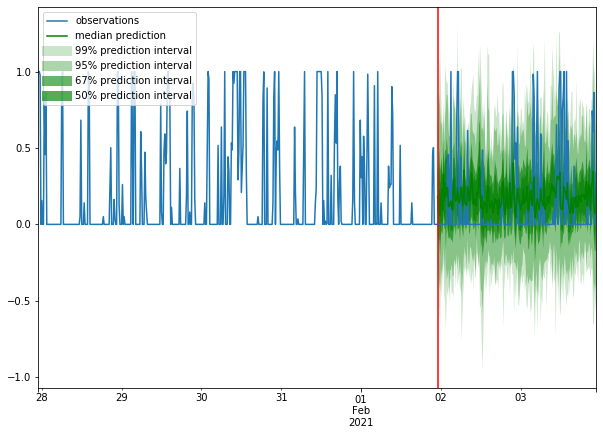

<Figure size 432x288 with 0 Axes>

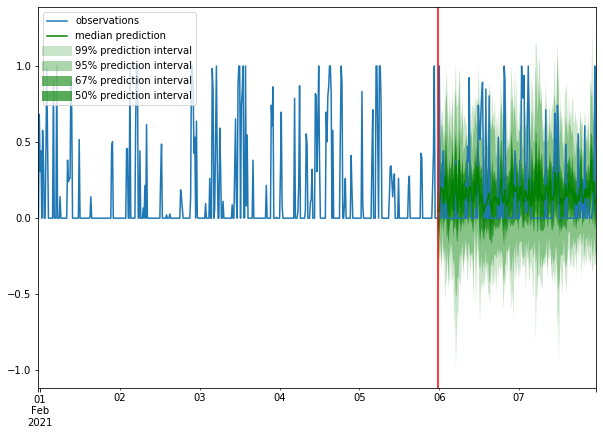

<Figure size 432x288 with 0 Axes>

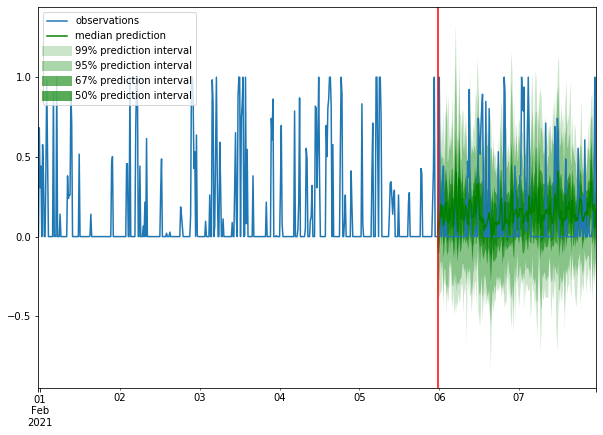

<Figure size 432x288 with 0 Axes>

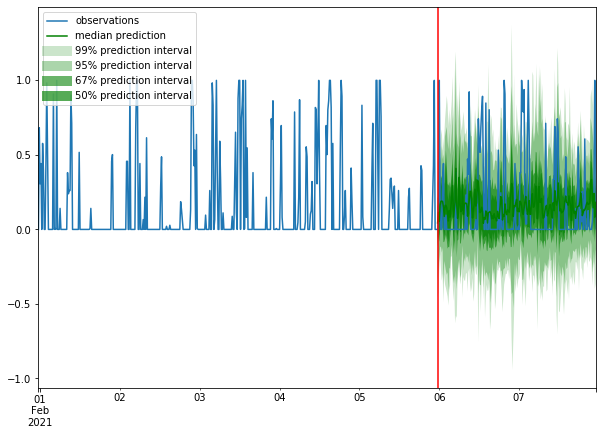

<Figure size 432x288 with 0 Axes>

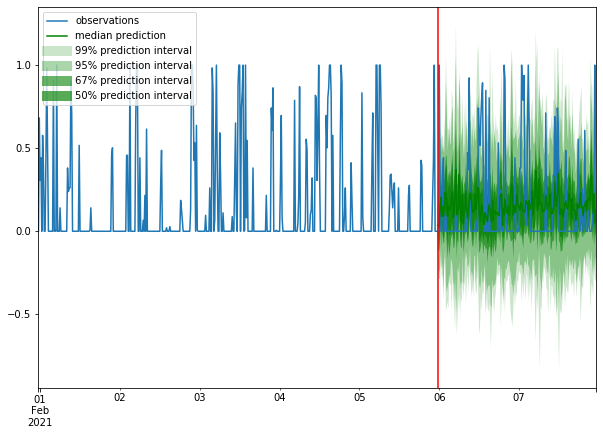

<Figure size 432x288 with 0 Axes>

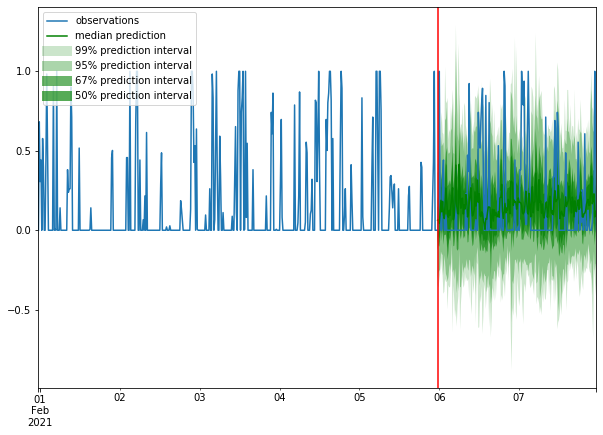

<Figure size 432x288 with 0 Axes>

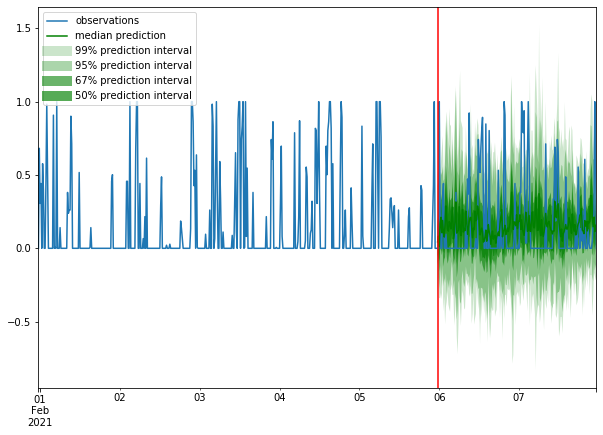

<Figure size 432x288 with 0 Axes>

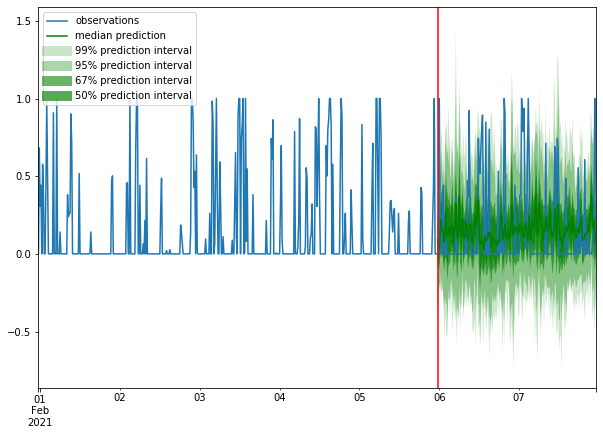

<Figure size 432x288 with 0 Axes>

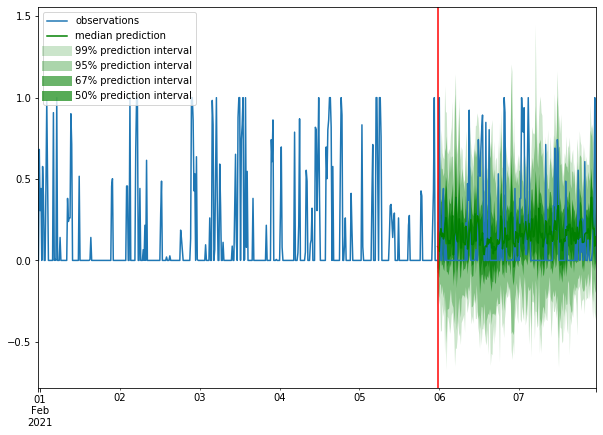


Saving time series predictions ...



Running evaluation:   0%|          | 0/82 [00:00<?, ?it/s]

Calculating time series prediction metrics ...


Running evaluation: 100%|██████████| 82/82 [00:00<00:00, 1361.45it/s]


{'Coverage[0.1]': 0.05373475609756097,
 'Coverage[0.2]': 0.28652184959349597,
 'Coverage[0.3]': 0.5158790650406504,
 'Coverage[0.4]': 0.6283663617886178,
 'Coverage[0.5]': 0.6620299796747968,
 'Coverage[0.6]': 0.6916285569105691,
 'Coverage[0.7]': 0.7254827235772358,
 'Coverage[0.8]': 0.7686737804878049,
 'Coverage[0.9]': 0.8203760162601628,
 'MAE_Coverage': 0.10745822041553749,
 'MAPE': 1.1273938566829542,
 'MASE': 1.1022650547513182,
 'MSE': 0.10277601634341524,
 'MSIS': 9.116077115195667,
 'ND': 1.165462422831176,
 'NRMSE': 1.4680973378251336,
 'OWA': nan,
 'QuantileLoss[0.1]': 1031.5341781295972,
 'QuantileLoss[0.2]': 1858.4844457362865,
 'QuantileLoss[0.3]': 2763.2944851307675,
 'QuantileLoss[0.4]': 3532.1550216692485,
 'QuantileLoss[0.5]': 4006.862090849376,
 'QuantileLoss[0.6]': 4156.022288186848,
 'QuantileLoss[0.7]': 4016.7070751234887,
 'QuantileLoss[0.8]': 3532.443131262064,
 'QuantileLoss[0.9]': 2596.34537127316,
 'RMSE': 0.32058698717105666,
 'abs_error': 4006.862094879150

,dataset,estimator,horizon,ND,NRMSE,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],Coverage[0.1],Coverage[0.5],Coverage[0.9]
0,"[down_power, up_power]",DeepAREstimator,192,1.165462,1.468097,0.300039,1.165462,0.75519,0.053735,0.66203,0.820376


<Figure size 432x288 with 0 Axes>

In [8]:

datasets = [
    ["down_power",
    "up_power"],
#     ["down_energy",
#     "up_energy"],
#     ["down_energy"],
#     ["up_energy"],
]

plot = True
save = False
ctx = mx.Context("cpu") #"gpu"
n_samples = 100
epochs = 50
num_batches_per_epoch = 20
learning_rate = 1e-4
freq = "15T"
context_length = 96*7
batch_size = 32
horizons = [96*2]
patience = 25

estimators = [
#     partial(
#         MeanEstimator,
#         num_samples=10
#     ),
#     partial(
#         GaussianProcessEstimator,
#         cardinality = 1,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=GaussianOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=StudentTOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=NegativeBinomialOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         MovingAveragePredictor,
#     ),
#     partial(
#         SeasonalNaivePredictor,
#     ),
    partial(
        DeepAREstimator,
        distr_output = GaussianOutput(),
        num_layers=3,
        trainer=Trainer(
            ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size, learning_rate=learning_rate, patience=patience
        ),
    ),
#     partial(
#         DeepAREstimator,
#         distr_output = StudentTOutput(), 
#         num_layers=3,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         DeepAREstimator,
#         distr_output = NegativeBinomialOutput(), 
#         num_layers=3,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=NegativeBinomialOutput(), #GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=StudentTOutput(), #GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     )
]


if __name__ == "__main__":
    import gluonts
    print(gluonts.__version__)
    print(mx.__version__)

    results = []
    for horizon in horizons:
        for dataset_name in datasets:
            for estimator in estimators:
                # catch exceptions that are happening during training to avoid failing the whole evaluation
                #try:
                evals = evaluate(dataset_name, estimator, horizon)
                results.append(evals)
                #except Exception as e:
                #    print(str(e))

                df = pd.DataFrame(results)

                sub_df = df[
                    [
                        "dataset",
                        "estimator",
                        "horizon",
                        "ND",
                        "NRMSE",
                        "wQuantileLoss[0.1]",
                        "wQuantileLoss[0.5]",
                        "wQuantileLoss[0.9]",
                        "Coverage[0.1]",
                        "Coverage[0.5]",
                        "Coverage[0.9]",
                    ]
                ]

                print(sub_df.to_string())
                if save:
                    sub_df.to_csv(r"./save/metrics_benchmarks_deepar_el.csv",index=False)
sub_df

0.5.2
1.6.0
Requesting query: SELECT max("down_energy")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2020-08-16 23:00:00' AND time < '2021-02-07 23:23:00' GROUP BY time(15m), "Type" fill(linear)
Retrieved data:                      down_energy
2020-08-16 23:00:00     0.000852
2020-08-16 23:15:00     0.010869
2020-08-16 23:30:00     0.004101
2020-08-16 23:45:00     0.012012
2020-08-17 00:00:00     0.000099
...                          ...
2021-02-07 22:15:00     0.000589
2021-02-07 22:30:00     0.002878
2021-02-07 22:45:00     0.086175
2021-02-07 23:00:00     0.004105
2021-02-07 23:15:00     0.000000

[16802 rows x 1 columns]
                     down_energy
2020-08-16 23:00:00     0.000852
2020-08-16 23:15:00     0.010869
2020-08-16 23:30:00     0.004101
2020-08-16 23:45:00     0.012012
2020-08-17 00:00:00     0.000099
...                          ...
2021-02-07 22:15:00     0.000589
2021-02-07 22:30:00     0.002878
2021-02-07 22:45:00     0.086175
2021-02-07 23:00:00     0.004


  0%|          | 0/20 [00:00<?, ?it/s]

Retrieved data:                      up_energy
2020-08-16 23:00:00  -0.000011
2020-08-16 23:15:00   0.000000
2020-08-16 23:30:00   0.000000
2020-08-16 23:45:00   0.000000
2020-08-17 00:00:00   0.000000
...                        ...
2021-02-07 22:15:00   0.000000
2021-02-07 22:30:00   0.000000
2021-02-07 22:45:00   0.000000
2021-02-07 23:00:00  -0.005712
2021-02-07 23:15:00  -0.009120

[16802 rows x 1 columns]
                     up_energy
2020-08-16 23:00:00   0.000011
2020-08-16 23:15:00   0.000000
2020-08-16 23:30:00   0.000000
2020-08-16 23:45:00   0.000000
2020-08-17 00:00:00   0.000000
...                        ...
2021-02-07 22:15:00   0.000000
2021-02-07 22:30:00   0.000000
2021-02-07 22:45:00   0.000000
2021-02-07 23:00:00   0.005712
2021-02-07 23:15:00   0.009120

[16802 rows x 1 columns]
train_target_values [[8.52258000e-04 1.08687160e-02 4.10114500e-03 ... 1.25310580e-02
  1.52165467e-01 1.67278898e-01]
 [1.14820000e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0

100%|██████████| 20/20 [00:21<00:00,  1.08s/it, epoch=50/50, avg_epoch_loss=-2.07]


Obtaining time series conditioning values ...



Obtaining time series predictions ...



Plotting time series predictions ...


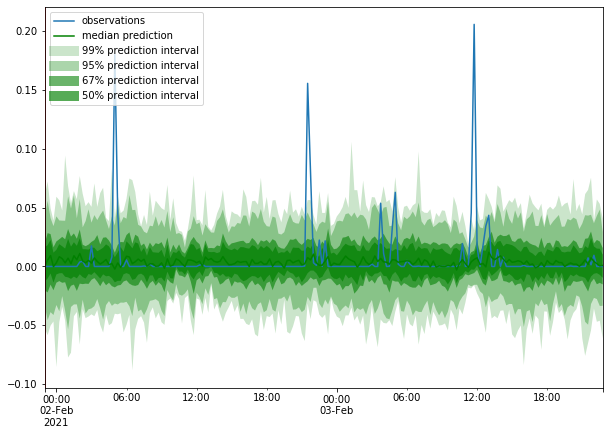

<Figure size 432x288 with 0 Axes>

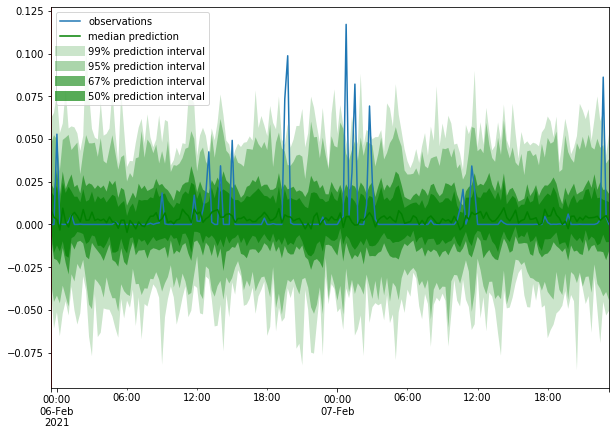

<Figure size 432x288 with 0 Axes>

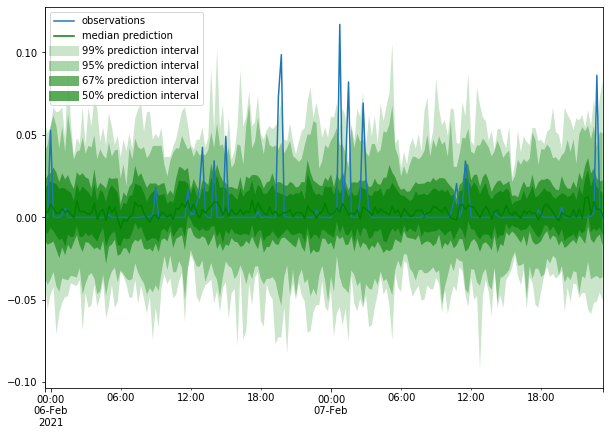

<Figure size 432x288 with 0 Axes>

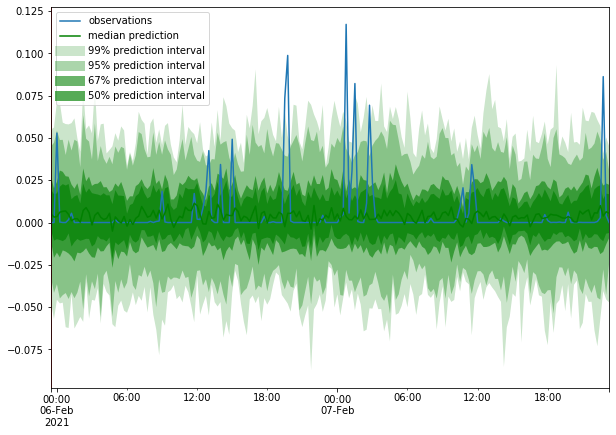

<Figure size 432x288 with 0 Axes>

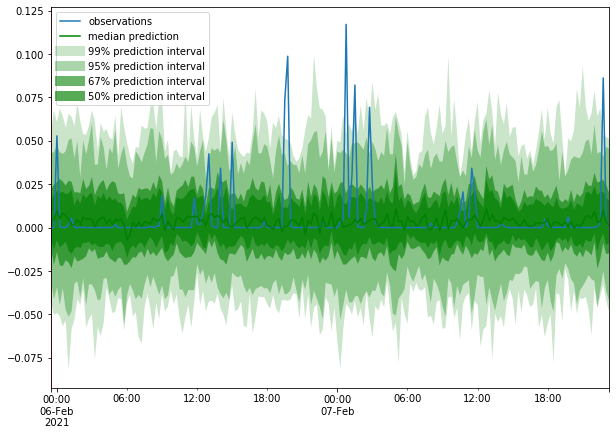

<Figure size 432x288 with 0 Axes>

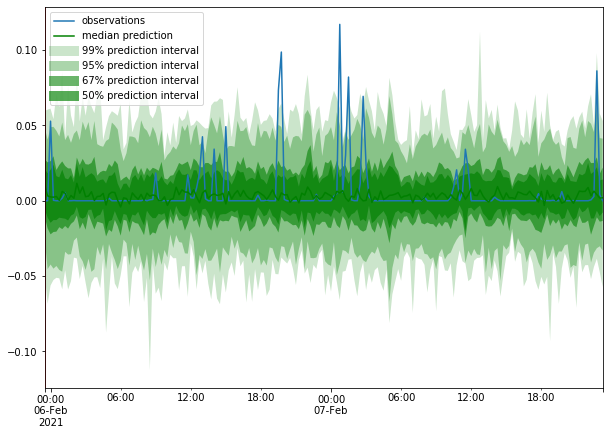

<Figure size 432x288 with 0 Axes>

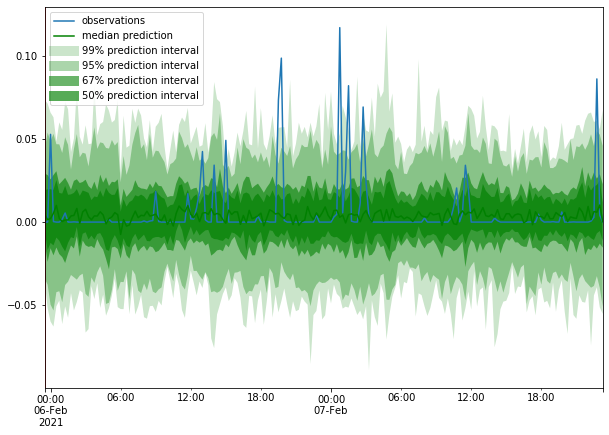

<Figure size 432x288 with 0 Axes>

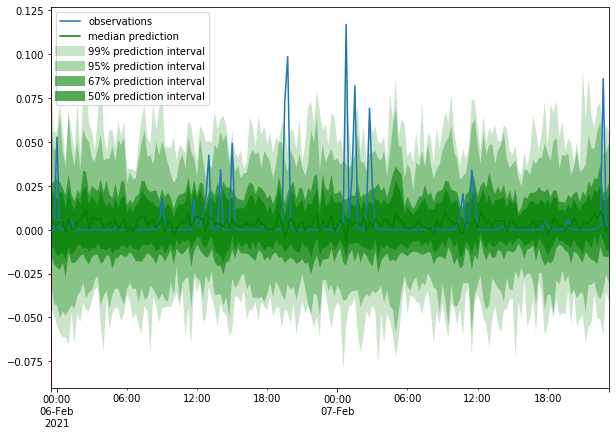

<Figure size 432x288 with 0 Axes>

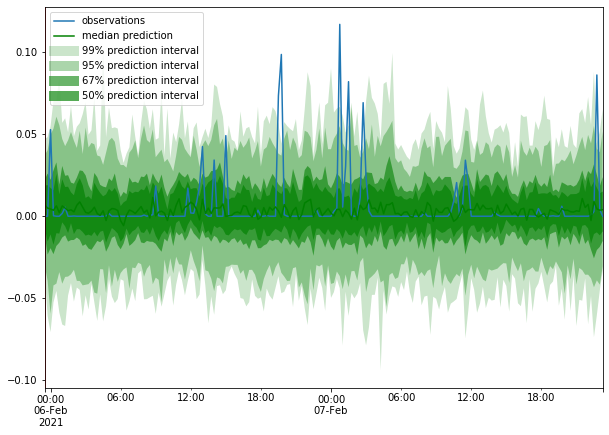


Saving time series predictions ...



Running evaluation:   0%|          | 0/82 [00:00<?, ?it/s]

Calculating time series prediction metrics ...


Running evaluation: 100%|██████████| 82/82 [00:00<00:00, 1945.22it/s]


{'Coverage[0.1]': 0.0,
 'Coverage[0.2]': 0.0,
 'Coverage[0.3]': 0.013528963414634146,
 'Coverage[0.4]': 0.26352896341463417,
 'Coverage[0.5]': 0.7185594512195121,
 'Coverage[0.6]': 0.8384146341463413,
 'Coverage[0.7]': 0.8826854674796747,
 'Coverage[0.8]': 0.9094258130081302,
 'Coverage[0.9]': 0.9313389227642277,
 'MAE_Coverage': 0.16704070686540196,
 'MAPE': 45.53107557828982,
 'MASE': 1.007510810214593,
 'MSE': 0.0007029809396074161,
 'MSIS': 17.976555571549543,
 'ND': 1.3064250105202875,
 'NRMSE': 3.051829118164922,
 'OWA': nan,
 'QuantileLoss[0.1]': 113.54849851941691,
 'QuantileLoss[0.2]': 155.8469103484182,
 'QuantileLoss[0.3]': 158.33966715612442,
 'QuantileLoss[0.4]': 145.51856273993602,
 'QuantileLoss[0.5]': 178.69447651617253,
 'QuantileLoss[0.6]': 223.36257823265987,
 'QuantileLoss[0.7]': 250.5317454196207,
 'QuantileLoss[0.8]': 246.5769682650454,
 'QuantileLoss[0.9]': 200.02360722972077,
 'RMSE': 0.026513787726528553,
 'abs_error': 178.69447696208954,
 'abs_target_mean': 0.

,dataset,estimator,horizon,ND,NRMSE,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],Coverage[0.1],Coverage[0.5],Coverage[0.9]
0,"[down_energy, up_energy]",DeepAREstimator,192,1.306425,3.051829,0.830147,1.306425,1.462361,0.0,0.718559,0.931339


<Figure size 432x288 with 0 Axes>

In [9]:

datasets = [
    ["down_energy",
    "up_energy"],
#     ["down_energy"],
#     ["up_energy"],
]

plot = True
save = False
ctx = mx.Context("cpu") #"gpu"
n_samples = 100
epochs = 50
num_batches_per_epoch = 20
learning_rate = 1e-4
freq = "15T"
context_length = 96*2
batch_size = 32
horizons = [96*2]
patience = 25

estimators = [
#     partial(
#         MeanEstimator,
#         num_samples=10
#     ),
#     partial(
#         GaussianProcessEstimator,
#         cardinality = 1,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=GaussianOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=StudentTOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=NegativeBinomialOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         MovingAveragePredictor,
#     ),
#     partial(
#         SeasonalNaivePredictor,
#     ),
    partial(
        DeepAREstimator,
        distr_output = GaussianOutput(),
        num_layers=3,
        trainer=Trainer(
            ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size, learning_rate=learning_rate, patience=patience
        ),
    ),
#     partial(
#         DeepAREstimator,
#         distr_output = StudentTOutput(), 
#         num_layers=3,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         DeepAREstimator,
#         distr_output = NegativeBinomialOutput(), 
#         num_layers=3,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=NegativeBinomialOutput(), #GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=StudentTOutput(), #GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     )
]


if __name__ == "__main__":
    import gluonts
    print(gluonts.__version__)
    print(mx.__version__)

    results = []
    for horizon in horizons:
        for dataset_name in datasets:
            for estimator in estimators:
                # catch exceptions that are happening during training to avoid failing the whole evaluation
                #try:
                evals = evaluate(dataset_name, estimator, horizon)
                results.append(evals)
                #except Exception as e:
                #    print(str(e))

                df = pd.DataFrame(results)

                sub_df = df[
                    [
                        "dataset",
                        "estimator",
                        "horizon",
                        "ND",
                        "NRMSE",
                        "wQuantileLoss[0.1]",
                        "wQuantileLoss[0.5]",
                        "wQuantileLoss[0.9]",
                        "Coverage[0.1]",
                        "Coverage[0.5]",
                        "Coverage[0.9]",
                    ]
                ]

                print(sub_df.to_string())
                if save:
                    sub_df.to_csv(r"./save/metrics_benchmarks_deepar_el.csv",index=False)
sub_df

In [6]:
sub_df

,dataset,estimator,horizon,ND,NRMSE,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],Coverage[0.1],Coverage[0.5],Coverage[0.9]
0,"[down_power, up_power]",DeepAREstimator,192,1.128639,1.387605,0.296668,1.128639,0.635368,0.059663,0.677822,0.855294
1,"[down_power, up_power]",DeepAREstimator,192,0.986885,1.642989,0.233076,0.986885,1.384549,0.007657,0.239389,0.557447
2,"[down_power, up_power]",DeepAREstimator,192,0.998793,1.404065,0.200000,0.998793,0.788614,0.000000,0.000816,0.776081
3,"[down_power, up_power]",CanonicalRNNEstimator,192,1.135626,1.467321,0.287725,1.135626,0.846825,0.022310,0.637243,0.790617
4,"[down_power, up_power]",CanonicalRNNEstimator,192,1.174383,2.048895,0.200000,1.174383,1.152766,0.000000,0.070623,0.970227
5,"[down_power, up_power]",CanonicalRNNEstimator,192,1.118047,1.466461,0.311494,1.118047,0.817024,0.010261,0.613106,0.800334


In [9]:
sub_df

,dataset,estimator,horizon,ND,NRMSE,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],Coverage[0.1],Coverage[0.5],Coverage[0.9]
0,[down_energy],DeepAREstimator,192,1.039788,3.827887,0.269032,1.039788,1.673162,0.011116,0.69232,0.836987
1,[down_energy],DeepAREstimator,192,1.009331,3.880766,0.259118,1.009331,1.702742,0.120958,0.64148,0.767257


0.5.2
1.6.0
Requesting query: SELECT max("down_energy")*1 FROM "dominoes" WHERE "Type"='FCR-N' AND  time >= '2020-08-16 23:00:00' AND time < '2021-01-18 23:23:00' GROUP BY time(15m), "Type" fill(linear)
Retrieved data:                      down_energy
2020-08-16 23:00:00     0.025323
2020-08-16 23:15:00     0.066944
2020-08-16 23:30:00     0.061151
2020-08-16 23:45:00     0.074074
2020-08-17 00:00:00     0.016725
...                          ...
2021-01-18 22:15:00     0.029028
2021-01-18 22:30:00     0.053451
2021-01-18 22:45:00     0.001415
2021-01-18 23:00:00     0.000395
2021-01-18 23:15:00     0.000007

[14882 rows x 1 columns]
                     down_energy
2020-08-16 23:00:00     0.025323
2020-08-16 23:15:00     0.066944
2020-08-16 23:30:00     0.061151
2020-08-16 23:45:00     0.074074
2020-08-17 00:00:00     0.016725
...                          ...
2021-01-18 22:15:00     0.029028
2021-01-18 22:30:00     0.053451
2021-01-18 22:45:00     0.001415
2021-01-18 23:00:00     0.000


  0%|          | 0/10 [00:00<?, ?it/s]

Retrieved data:                      up_energy
2020-08-16 23:00:00  -0.018602
2020-08-16 23:15:00  -0.003200
2020-08-16 23:30:00  -0.001940
2020-08-16 23:45:00  -0.006448
2020-08-17 00:00:00  -0.022578
...                        ...
2021-01-18 22:15:00  -0.015431
2021-01-18 22:30:00  -0.011818
2021-01-18 22:45:00  -0.090383
2021-01-18 23:00:00  -0.088121
2021-01-18 23:15:00  -0.110579

[14882 rows x 1 columns]
                     up_energy
2020-08-16 23:00:00   0.018602
2020-08-16 23:15:00   0.003200
2020-08-16 23:30:00   0.001940
2020-08-16 23:45:00   0.006448
2020-08-17 00:00:00   0.022578
...                        ...
2021-01-18 22:15:00   0.015431
2021-01-18 22:30:00   0.011818
2021-01-18 22:45:00   0.090383
2021-01-18 23:00:00   0.088121
2021-01-18 23:15:00   0.110579

[14882 rows x 1 columns]
train_target_values [[0.02532258 0.06694431 0.06115141 ... 0.07441744 0.18521419 0.19572378]
 [0.01860221 0.00319965 0.0019398  ... 0.00106638 0.         0.        ]]
test_target_values [[

100%|██████████| 10/10 [00:18<00:00,  1.83s/it, epoch=100/100, avg_epoch_loss=-2.44]


Obtaining time series conditioning values ...



Obtaining time series predictions ...



Plotting time series predictions ...


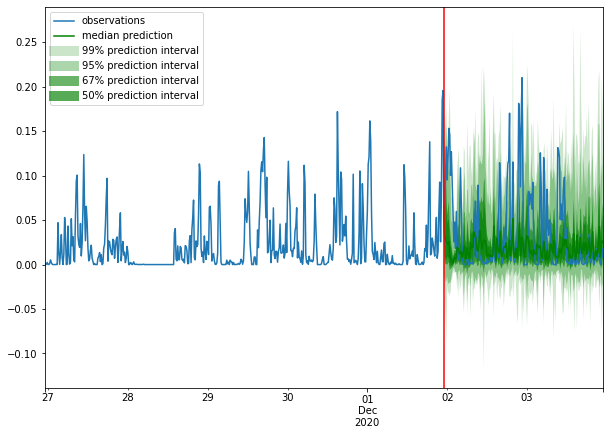

<Figure size 432x288 with 0 Axes>

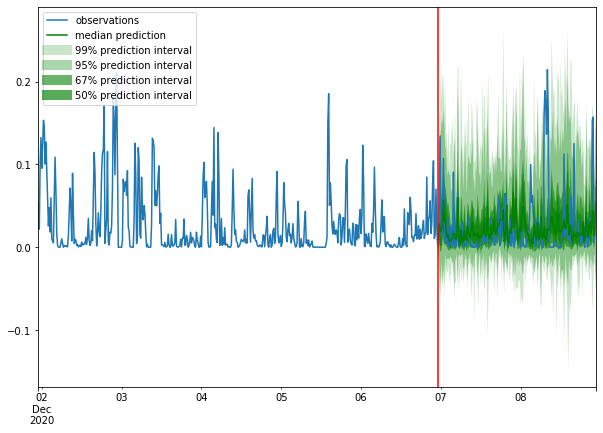

<Figure size 432x288 with 0 Axes>

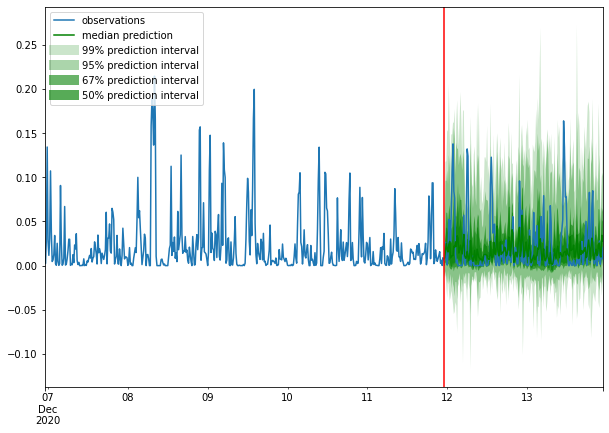

<Figure size 432x288 with 0 Axes>

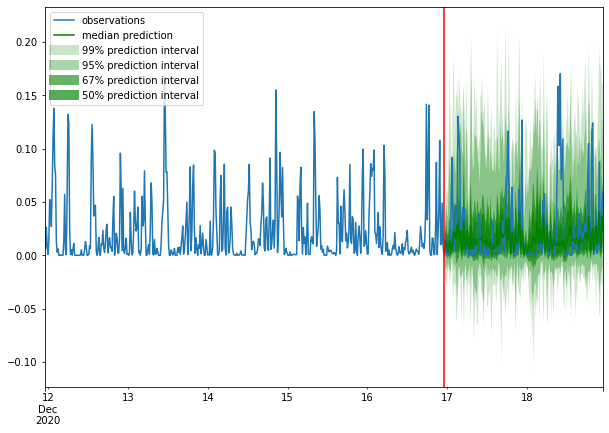

<Figure size 432x288 with 0 Axes>

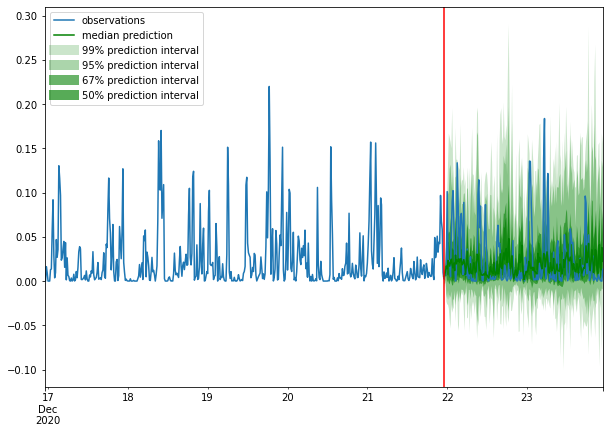

<Figure size 432x288 with 0 Axes>

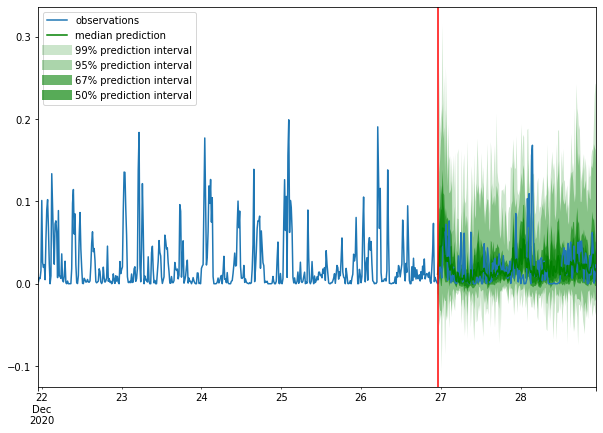

<Figure size 432x288 with 0 Axes>

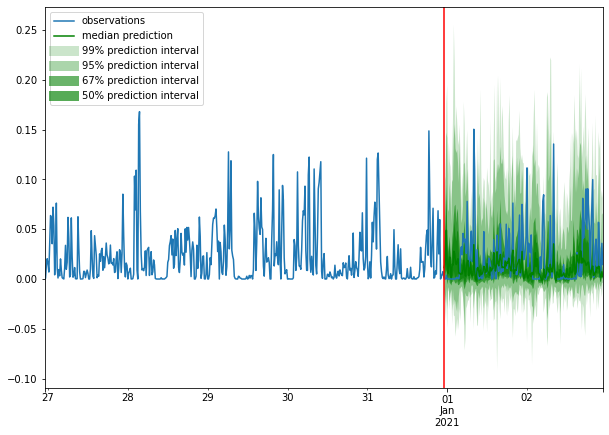

<Figure size 432x288 with 0 Axes>

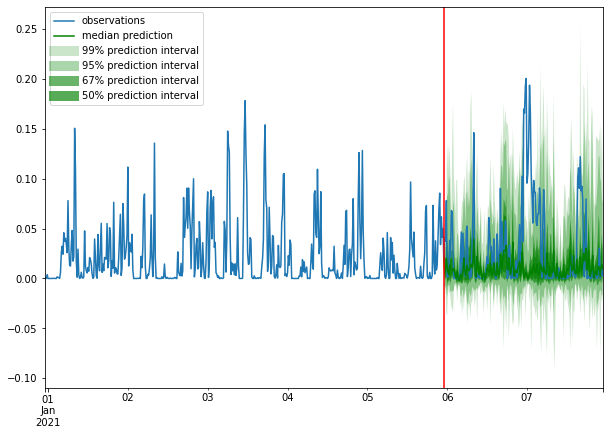

<Figure size 432x288 with 0 Axes>

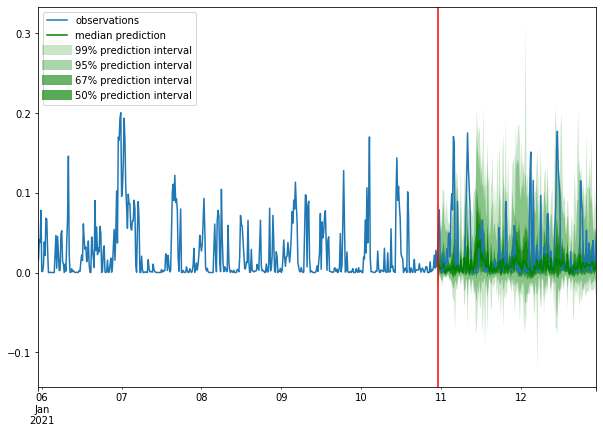

<Figure size 432x288 with 0 Axes>

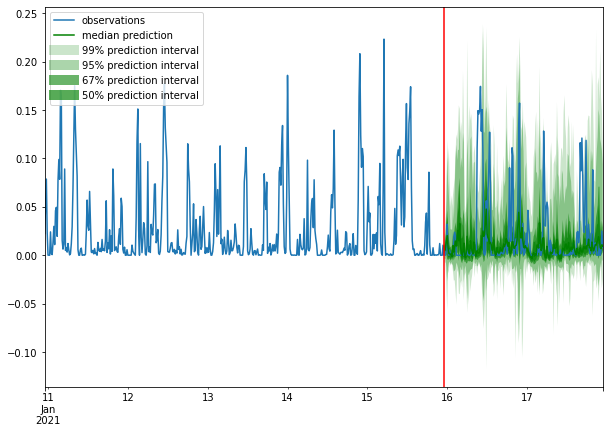


Running evaluation:   0%|          | 0/94 [00:00<?, ?it/s]


Saving time series predictions ...
Calculating time series prediction metrics ...


Running evaluation: 100%|██████████| 94/94 [00:00<00:00, 1008.76it/s]


{'Coverage[0.1]': 0.024878102836879436,
 'Coverage[0.2]': 0.1667220744680851,
 'Coverage[0.3]': 0.32153147163120566,
 'Coverage[0.4]': 0.43788785460992913,
 'Coverage[0.5]': 0.5304742907801419,
 'Coverage[0.6]': 0.6032801418439716,
 'Coverage[0.7]': 0.6811281028368795,
 'Coverage[0.8]': 0.7605828900709221,
 'Coverage[0.9]': 0.8398714539007092,
 'MAE_Coverage': 0.035554570527974776,
 'MAPE': 53.432602213198024,
 'MASE': 1.1327325954359324,
 'MSE': 0.0020240214203339044,
 'MSIS': 10.02252213912771,
 'ND': 0.7941925112701945,
 'NRMSE': 1.180533970301802,
 'OWA': nan,
 'QuantileLoss[0.1]': 153.2597344740015,
 'QuantileLoss[0.2]': 271.01364994695615,
 'QuantileLoss[0.3]': 381.937672765201,
 'QuantileLoss[0.4]': 475.8586017147471,
 'QuantileLoss[0.5]': 546.2405438837832,
 'QuantileLoss[0.6]': 584.1654129556047,
 'QuantileLoss[0.7]': 586.6843619002661,
 'QuantileLoss[0.8]': 536.4354282167506,
 'QuantileLoss[0.9]': 405.3382875905606,
 'RMSE': 0.04498912557867628,
 'abs_error': 546.240545988082

,dataset,estimator,horizon,ND,NRMSE,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],Coverage[0.1],Coverage[0.5],Coverage[0.9]
0,"[down_energy, up_energy]",DeepAREstimator,192,0.794193,1.180534,0.222828,0.794193,0.589331,0.024878,0.530474,0.839871


<Figure size 432x288 with 0 Axes>

In [11]:

datasets = [
    ["down_energy",
    "up_energy"],
#     ["down_energy"],
#     ["up_energy"],
]

plot = True
save = False
ctx = mx.Context("cpu") #"gpu"
n_samples = 100
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-3
freq = "15T"
context_length = 96*7
batch_size = 32
horizons = [96*2]
patience = 25

estimators = [
#     partial(
#         MeanEstimator,
#         num_samples=10
#     ),
#     partial(
#         GaussianProcessEstimator,
#         cardinality = 1,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=GaussianOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=StudentTOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         SimpleFeedForwardEstimator,
#         distr_output=NegativeBinomialOutput(),
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         MovingAveragePredictor,
#     ),
#     partial(
#         SeasonalNaivePredictor,
#     ),
    partial(
        DeepAREstimator,
        distr_output = GaussianOutput(),
        num_layers=3,
        trainer=Trainer(
            ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size, learning_rate=learning_rate, patience=patience
        ),
    ),
#     partial(
#         DeepAREstimator,
#         distr_output = StudentTOutput(), 
#         num_layers=3,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         DeepAREstimator,
#         distr_output = NegativeBinomialOutput(), 
#         num_layers=3,
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         ),
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=NegativeBinomialOutput(), #GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     ),
#     partial(
#         CanonicalRNNEstimator,
#         distr_output=StudentTOutput(), #GaussianOutput(), #StudentTOutput(),
#         num_layers=2,
#         num_cells=100,
#         cardinality = [1],
#         trainer=Trainer(
#             ctx=ctx, epochs=epochs, num_batches_per_epoch=num_batches_per_epoch,
#             batch_size=batch_size, learning_rate=learning_rate, patience=patience
#         )
#     )
]


if __name__ == "__main__":
    import gluonts
    print(gluonts.__version__)
    print(mx.__version__)

    results = []
    for horizon in horizons:
        for dataset_name in datasets:
            for estimator in estimators:
                # catch exceptions that are happening during training to avoid failing the whole evaluation
                #try:
                evals = evaluate(dataset_name, estimator, horizon)
                results.append(evals)
                #except Exception as e:
                #    print(str(e))

                df = pd.DataFrame(results)

                sub_df = df[
                    [
                        "dataset",
                        "estimator",
                        "horizon",
                        "ND",
                        "NRMSE",
                        "wQuantileLoss[0.1]",
                        "wQuantileLoss[0.5]",
                        "wQuantileLoss[0.9]",
                        "Coverage[0.1]",
                        "Coverage[0.5]",
                        "Coverage[0.9]",
                    ]
                ]

                print(sub_df.to_string())
                if save:
                    sub_df.to_csv(r"./save/metrics_benchmarks_deepar_el.csv",index=False)
sub_df

In [13]:
sub_df[sub_df>0]

TypeError: '>' not supported between instances of 'list' and 'int'